# Criando Previsões de Séries Temporais

Neste notebook irei abordar os princípios básicos para se criar uma previsão de séries temporais.

Ao nosso redor existem padrões que se repetem constantemente durante o tempo, pode-se notar padrões repetitivos no clima, com as estações do tempo; no trânsito, com os horários de pico de ida e volta ao trabalho e escola; nas batidas do coração, onde procura-se padrões fora da normalidade; em ações da bolsa de valores, como também em nos ciclos de venda de determinados produtos.

Analisar séries temporais são úteis para verificar esses padrões e criar previsões de movimentos futuros. Existem diversas maneiras de se criar essas previsões, nesse post irei abordar os conceitos das metodologias mais básicas e tradicionais.

In [1]:
#importando bibliotecas essenciais
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Série Estacionária

Uma série temporal estacionária é aquela cujas propriedades estatísticas, como a média, a variância e a autocorrelação, são constantes ao longo do tempo. Assim, uma série não estacionária é uma cujas propriedades estatísticas mudam com o tempo.

Antes de iniciar qualquer modelagem preditiva é necessário verificar se essas propriedades estatísticas são constantes, abaixo explicarei cada um desses pontos:

* Média constante
* Com variância constante
* Auto correlacionada

### Média Constante

Uma série estacionária tem média constante durante o tempo, não existe tendências de alta ou de baixa. A razão disso é que tendo uma média constante com variações ao redor desta média fica muito mais fácil de extrapolar ao futuro.

Há casos que a variância é pequena em relação à média e usá-la pode ser uma boa métrica para fazer previsões para o futuro, abaixo um gráfico para mostrar a média em relação as variações ao longo do tempo:

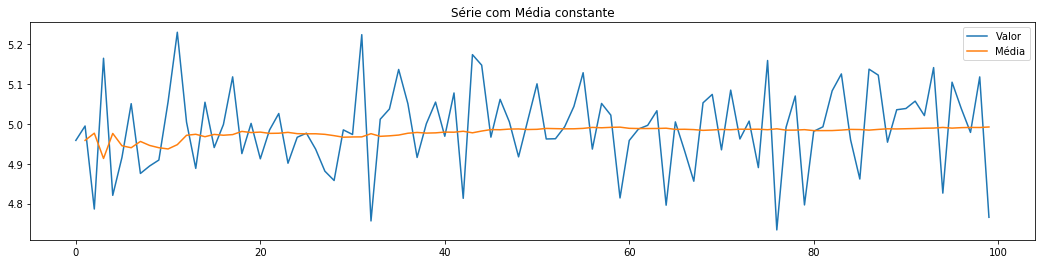

In [2]:
np.random.seed(2)
rand = [5] * 100 + np.random.randn(100) * 0.1

#Criando uma média que se expande do primeiro valor e acumulado até cada dia anterior
mean = [np.mean(rand[:x]) for x in range(len(rand))]
plt.figure(figsize=(18,4))
plt.plot(rand, label='Valor')
plt.plot(mean, label='Média')
plt.title('Série com Média constante')
plt.legend()
plt.show()

Caso a série não seja estacionária a previsão para o futuro não será eficiente, pois as variações de valores ao redor da média se afastam significativamente como pode ser visto abaixo:

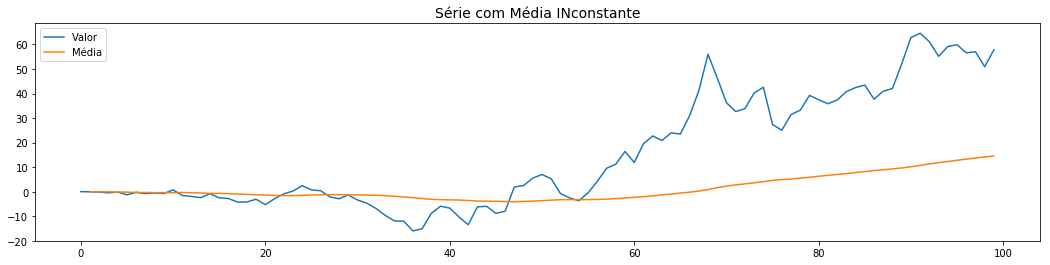

In [3]:
np.random.seed(1)
rand2 = np.cumsum([x for x in range(100) * np.random.randn(100) * 0.1])

#Criando uma média que se expande do primeiro valor e acumulado até cada dia anterior
mean2 = [np.mean(rand2[:x]) for x in range(len(rand2))]
plt.figure(figsize=(18,4))
plt.plot(rand2, label='Valor')
plt.plot(mean2, label='Média')
plt.title('Série com Média INconstante', fontdict={'fontsize':14})
plt.legend()
plt.show()

No gráfico acima claramente nota-se uma tendência de alta e a média gradativamente subindo, neste caso se a média fosse usada para fazer previsões futuras o erro ia ser significante, pois os preços previstos estariam sempre abaixo do preço real.

### Variância Constante

Quando a série tem variância constante, temos ideia da variação padrão em relação à média, quando a variância não é constante (como imagem abaixo) a previsão provavelmente vai ter erros maiores em determinados períodos e estes períodos não serão previsíveis, pois nestes casos espera-se que a variância permaneça inconstante durante o tempo, inclusive no futuro.

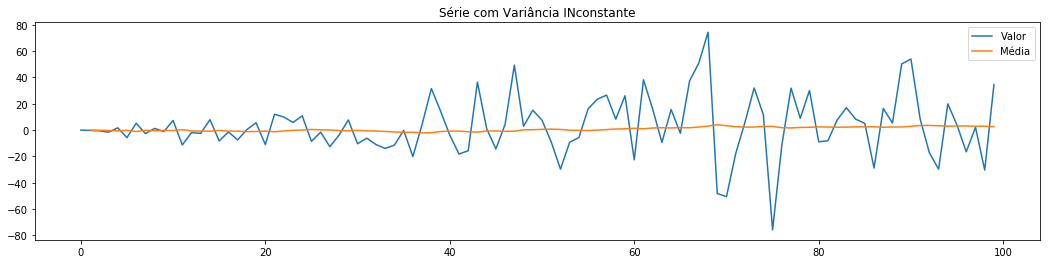

In [4]:
np.random.seed(1)
rand3 = [x for x in range(100) * np.random.randn(100) * 0.5]

#Criando uma média que se expande do primeiro valor e acumulado até cada dia anterior
mean3 = [np.mean(rand3[:x]) for x in range(len(rand3))]
plt.figure(figsize=(18,4))
plt.plot(rand3, label='Valor')
plt.plot(mean3, label='Média')
plt.title('Série com Variância INconstante')
plt.legend()
plt.show()

Para diminuir o efeito da variância, pode-se aplicar a transformação logarítmica, transformação de escalas exponenciais como o método Box-Cox ou deflacionar a série, caso faça sentido.

### Série Autocorrelacionada

Quando duas variáveis tem variação semelhante em relação ao desvio padrão pode-se dizer que as variáveis são correlacionadas, um exemplo seria o aumento do peso corporal com doenças do coração, quanto maior o peso maior a incidência de problemas no coração, neste caso a correlação é positiva e o gráfico seria algo semelhante a este:

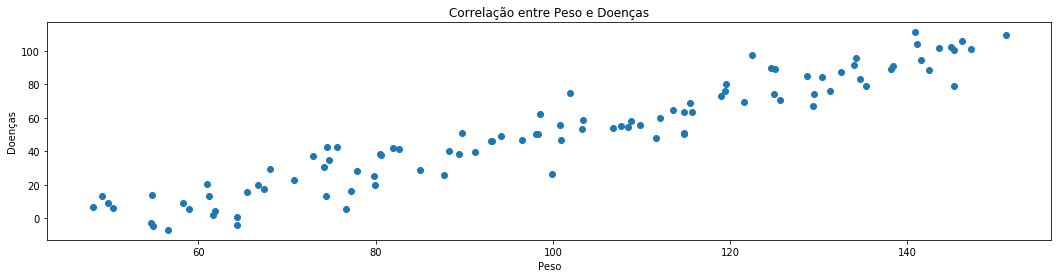

In [5]:
np.random.seed(1)
peso = [x for x in range(50,150)] + np.random.randn(100) * 3
caso_doencas = [x for x in range(100)] + np.random.randn(100) * 10

plt.figure(figsize=(18,4))
plt.scatter(peso, caso_doencas)
plt.xlabel('Peso')
plt.ylabel('Doenças')
plt.title('Correlação entre Peso e Doenças')
plt.show()

Um caso de correlação negativa seria quanto maior o gasto com segurança no trabalho menor seria a quantidade de acidentes que ocorreriam.

Abaixo vários exemplos de gráficos de dispersão com os níveis de correlação:

![image](Correlation_examples2.png)

Quando o assunto é **<font color='red'>Autocorrelação</font>**, significa que existe uma correlação de determinados períodos anteriores com o período atual, o nome que se dá ao período com esta correlação é **lag**, exemplo: em uma série que tem medições a cada hora, a temperatura de hoje às 12:00h é muito semelhante à temperatura de 24 horas atrás, neste caso há uma auto correlação dos valores atuais com o 24º lag.

Existir auto correlação é condição para se criar previsões com uma única variável, pois caso não exista essa correlação não pode-se usar valores passados para prever o futuro, quando existem diversas variáveis, pode-se verificar se há correlação entre a variável dependente e os lags das variáveis independentes.

Caso uma série não tenha auto correlação ela é uma série com sequências aleatória e imprevisíveis e a melhor maneira de se fazer uma previsão normalmente é usar o valor do dia anterior. Usarei de gráficos e explicações mais detalhadas a seguir.

A partir daqui irei analisar os preços semanais do etanol Hidratado da Esalq, os dados podem ser baixados [aqui](https://www.cepea.esalq.usp.br/br/indicador/etanol.aspx).

In [6]:
#Importando os dados e transformando o preço para a base de R$/m3
df = pd.read_excel('/Users/lvrsilva/OneDrive/Medium Posts/Princípios de Séries Temporais/EsalqHidr.xls')
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.sort_values('Data')
df.set_index('Data', inplace=True)
df.columns = ['Preço']
df['Preço'] *= 1000
df.head()

,Preço
Data,
2002-11-29,684.2
2002-12-06,689.7
2002-12-13,692.6
2002-12-20,706.5
2002-12-27,694.1


Antes de se iniciar qualquer analise, vamos dividir os dados em base de treino e de teste

## Dividindo os dados em base de treinamento e de teste

Quando vamos criar um modelo de previsão de séries temporais o ideal é separar os dados em duas partes:

* **Treino**: estes dados serão a base principal para definir os coeficientes/parâmetros do modelo;
* **Teste**: são dados que serão separados e não foram vistos pelo modelo e serão usados para testá-lo e comparar com as previsões (geralmente comparando os valores passo-a-passo).

O tamanho do conjunto de testes é normalmente cerca de 20% da amostra total, embora esse percentual dependa do tamanho da amostra que você tenha e também quanto tempo adiante você deseja fazer a previsão. A base de testes deve ser idealmente pelo menos tão grande quanto o horizonte máximo de previsão necessário.

Diferente de outros métodos de previsões, como classificações e regressões sem a influência do tempo, em séries temporais não podemos dividir os dados de treino e teste com amostras aleatórias de qualquer parte dos dados, deve-se seguir o critério temporal da série, onde os dados de treino devem vir antes dos dados de teste. 

Neste exemplo dos preços do Hidratado temos 856 semanas, onde usaremos como base de treino as primeiras 700 semanas e as últimas 156 semanas (3 anos ~18%) usaremos como base de testes:

In [7]:
semanas = 156
treino = df.iloc[:-semanas,0:1].copy()
teste = df.iloc[-semanas:,0:1].copy()

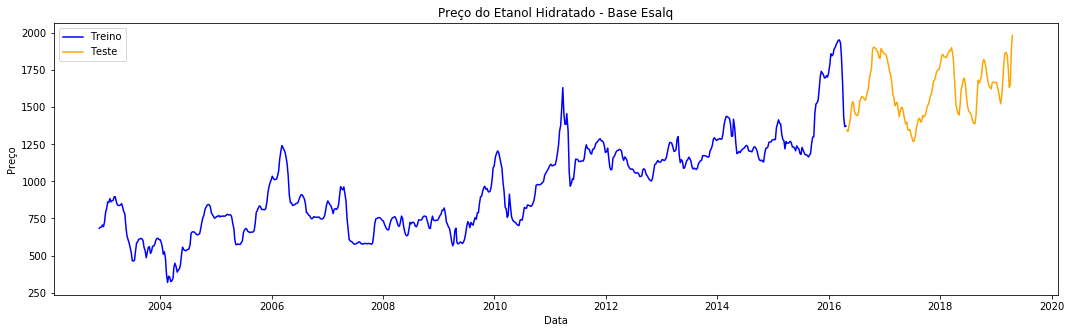

In [8]:
plt.figure(figsize=(18,5))
plt.title('Preço do Etanol Hidratado - Base Esalq')
plt.plot(treino['Preço'], color='b')
plt.plot(teste['Preço'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

A partir de agora só iremos usar a base de **treino** para fazer os estudos, a base de **teste** será somente usada para validar as previsões que iremos fazer.

Toda série temporal pode ser decomposta em 3 partes: **tendência**, **sazonalidade** e **resíduo**, que é o que resta após retirar da série as duas primeiras partes, abaixo a separação dessas partes:

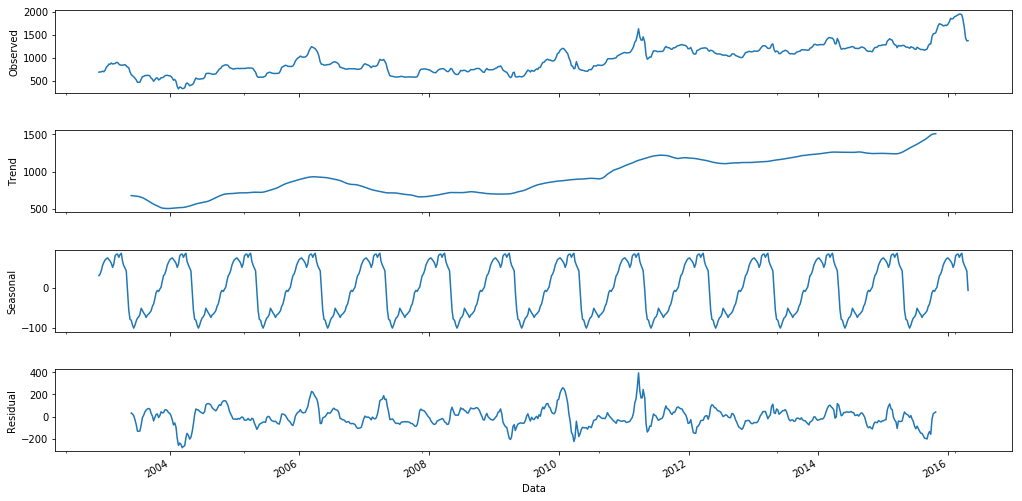

In [9]:
#gráfico semanal com ciclos que se repetem a cada 52 semanas (1 ano)
season = seasonal_decompose(treino, freq=52)
fig = season.plot();
fig.set_size_inches(16,8)

Claramente a série tem uma tendência de alta, com picos entre o final e inicio de anos e mínimas entre abril e setembro (início da moagem de cana no centro-sul do Brasil).

Porém é indicado utilizar testes estatísticos para confirmar se a séries é estacionária, vamos usar dois testes: o teste de [Dickey Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) e o teste [KPSS](https://en.wikipedia.org/wiki/KPSS_test).

Primeiramente vamos usar o teste de Dickey Fuller, usarei o [valor P](https://pt.wikipedia.org/wiki/Valor-p) base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária. 

Além disso, existe o **Teste estatístico** do modelo, onde estes valores podem ser comparados com os **valores críticos** de 1%, 5% e 10%, caso o teste estatístico esteja abaixo de algum valor critico escolhido a série será estacionária:

In [10]:
#Teste de Dickey Fuller
adfinput = adfuller(treino['Preço'])
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
adftest

Teste Estatistico Dickey Fuller     -1.8323
Valor-P                              0.3646
Lags Usados                          6.0000
Número de observações usadas       693.0000
Valores Críticos (1%)               -3.4398
Valores Críticos (5%)               -2.8657
Valores Críticos (10%)              -2.5690
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série não é estacionária (Valor P de 36% e o valor crítico de 5% é menor que o teste estatístico)

Agora vamos analisar a série com o teste **KPSS**, ao contrário do teste de Dickey Fuller, o teste KPSS já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5% ou o teste estatístico for menor que algum valor crítico escolhido:

In [11]:
kpss_input = kpss(treino['Preço'])
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       2.5643
Valor-P                     0.0100
Lags Usados                20.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

Confirmando o teste de Dickey Fuller, o teste KPSS também mostra que a série não é estacionária, pois o valor P está em 1% e o teste estatístico está acima de qualquer valor crítico.

A seguir irei demonstrar maneiras de transformar uma série para que ela fique estacionária.

## Transformando a série em estacionária

### Diferenciação

A diferenciação é usada para remover os sinais de tendências e reduzir a variância, ela simplesmente é a diferença do valor do período **T** com o valor do período anterior **T-1**.

Para ficar mais fácil o entendimento, abaixo pegamos somente uma fração dos preços do etanol para melhor visualização, note a partir de mai/05 os preços começam a subir até meados de mai/06, os preços tem subidas semanais que se acumulam criando uma tendência de alta, este é um caso de série não estacionária.

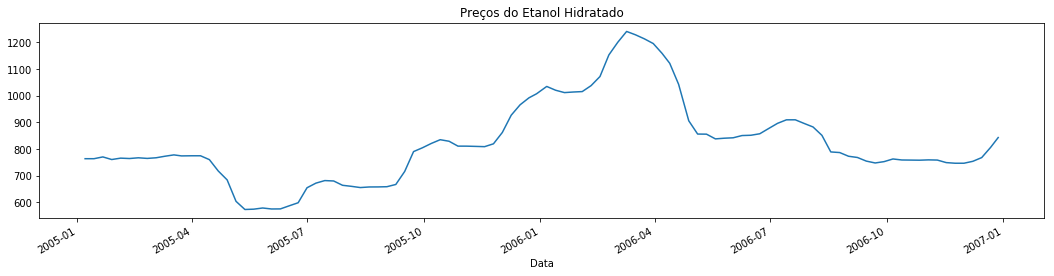

In [12]:
treino.loc['2005':'2006','Preço'].plot(figsize=(18,4), title='Preços do Etanol Hidratado')
plt.show()

Ao se fazer a primeira diferenciação (gráfico abaixo), retiramos o efeito acumulado da série e só mostramos a variação do período **T** contra o período **T-1** ao longo de toda a série, assim, se o preço de 3 dias atrás estiver a R\$ 800,00 e variou para R\$ 850,00, o valor da diferenciação será de R\$ 50,00 e se o valor de hoje estiver a R\$ 860,00 então a diferença será de -R\$ 10,00.

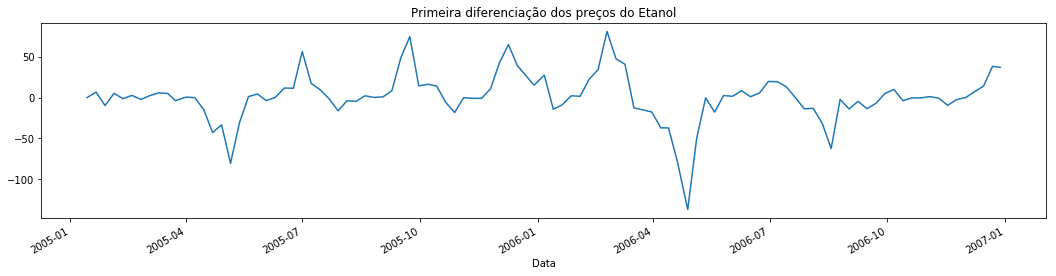

Mostrando as 10 primeiras diferenciações
Data
2002-12-06     5.5
2002-12-13     2.9
2002-12-20    13.9
2002-12-27   -12.4
2003-01-03    34.0
2003-01-10    64.6
2003-01-17    26.8
2003-01-24    41.5
2003-01-31    -3.3
2003-02-07    26.3
Name: Preço, dtype: float64


In [13]:
treino.loc['2005':'2006','Preço'].diff().dropna().plot(figsize=(18,4), title='Primeira diferenciação dos preços do Etanol')
plt.show()
print('Mostrando as 10 primeiras diferenciações')
print(treino['Preço'].diff().dropna().head(10))

Normalmente só é necessário uma diferenciação para transformar uma série em estacionária, mas caso seja necessário, pode-se aplicar uma segunda diferenciação, neste caso a diferenciação será sobre a primeira diferenciação (dificilmente haverá casos com mais do que 2 diferenciações). 

Usando o mesmo exemplo, para se fazer uma segunda diferenciação devemos pegar a diferenciação de **T** menos **T-1**: R\$ 2.9 - R\$ 5,5 = -R\$ 2,6 e assim por diante.

In [14]:
# diferenciação da diferenciação
print('Segunda Diferenciação')
treino['Preço'].diff().diff().dropna().head(10)

Segunda Diferenciação


Data
2002-12-13    -2.6
2002-12-20    11.0
2002-12-27   -26.3
2003-01-03    46.4
2003-01-10    30.6
2003-01-17   -37.8
2003-01-24    14.7
2003-01-31   -44.8
2003-02-07    29.6
2003-02-14   -48.2
Name: Preço, dtype: float64

Vamos fazer o teste de Dickey fuller para ver se a série ficará estacionária com a primeira diferenciação:

In [15]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def adfuller_test(serie, figsize=(18,4), plot=True, title=""):
    if plot:
        serie.plot(figsize=figsize, title=title)
        plt.show()
    #Teste de Dickey Fuller sobre a primeira diferenciação
    adf = adfuller(serie)
    output = pd.Series(adf[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
    output = round(output,4)
    
    for key, value in adf[4].items():
        output["Valores Críticos (%s)"%key] = value.round(4) 
    return output

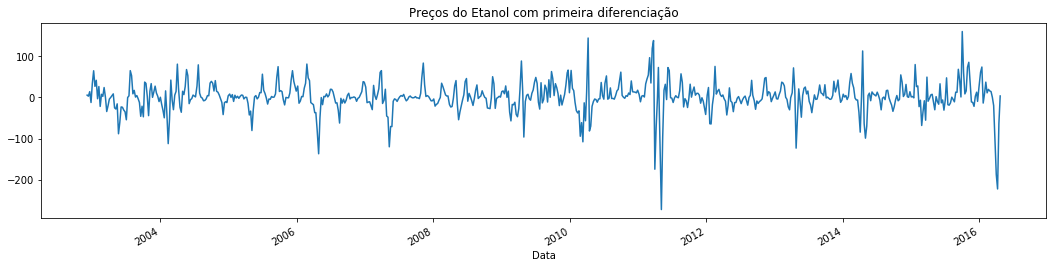

Teste Estatistico Dickey Fuller    -11.0140
Valor-P                              0.0000
Lags Usados                          5.0000
Número de observações usadas       693.0000
Valores Críticos (1%)               -3.4398
Valores Críticos (5%)               -2.8657
Valores Críticos (10%)              -2.5690
dtype: float64

In [16]:
adfuller_test(treino['Preço'].diff().dropna(), title='Preços do Etanol com primeira diferenciação')

Neste caso confirmamos que a série está estácionária, o valor P está zerado e se formos comparar, o valor do teste estatístico está muito abaixo dos valores críticos.

Próximo exemplo para tentar transformar uma série em estacionária é usar o ajuste de inflação.

### Ajuste de Inflação

Preços de produtos são relativos ao tempo que foram negociados, em 2002 o preço do etanol estava a R\$ 680,00, se o preço deste produto fosse negociado neste preço nos dias de hoje certamente muitas usinas estariam fechadas, pois é muito baixo. 


Para tentar tornar a série estacionária, irei colocar a série toda com base nos valores atuais pelo IPCA, acumulando do final do treino (abr/16) até o início do estudo, a fonte dos dados está no site do [IBGE](https://agenciadenoticias.ibge.gov.br/agencia-detalhe-de-midia.html?view=mediaibge&catid=2102&id=2807).

In [17]:
infl = pd.read_excel('IPCA.xlsx', sheet_name='IPCA')
infl['Data'] = pd.to_datetime(infl['Data'])
infl.set_index('Data', inplace=True)
infl.head()

,ANO,Mês,IPCA,Acumulado
Data,,,,
2002-11-01,2002,11,0.0302,2.392219
2002-12-01,2002,12,0.0210,2.322092
2003-01-01,2003,1,0.0225,2.274331
2003-02-01,2003,2,0.0157,2.224284
2003-03-01,2003,3,0.0123,2.189903


In [18]:
#Criando colunas de Ano e Mês para mesclar os dados com a base do IPCA
treino['ANO'] = treino.index.year
treino['Mês'] = treino.index.month

#Mesclando
index = treino.index
treino = treino.merge(infl.loc[:,['ANO','Mês','Acumulado']], how='left', on=['ANO','Mês'])
treino['Preço Ajustado'] = treino['Preço'] * treino['Acumulado']
treino.set_index(index, inplace=True)
treino.dropna(inplace=True)
treino.head()

,Preço,ANO,Mês,Acumulado,Preço Ajustado
Data,,,,,
2002-11-29,684.2,2002,11,2.392219,1636.756251
2002-12-06,689.7,2002,12,2.322092,1601.546744
2002-12-13,692.6,2002,12,2.322092,1608.280810
2002-12-20,706.5,2002,12,2.322092,1640.557887
2002-12-27,694.1,2002,12,2.322092,1611.763948


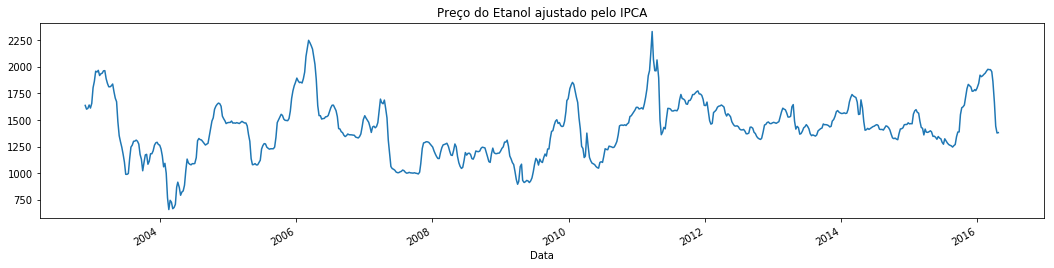

Teste Estatistico Dickey Fuller     -4.1294
Valor-P                              0.0009
Lags Usados                          6.0000
Número de observações usadas       693.0000
Valores Críticos (1%)               -3.4398
Valores Críticos (5%)               -2.8657
Valores Críticos (10%)              -2.5690
dtype: float64

In [19]:
adfuller_test(treino['Preço Ajustado'],title='Preço do Etanol ajustado pelo IPCA')

Como pode ser visto, a tendência de alta desapareceu, ficando somente as oscilações sazonais, o teste de Dickey Fuller também confirma que a séries agora é estacionária.

Apenas por questão de curiosidade, veja abaixo o gráfico com o preço com ajuste de inflação contra o original

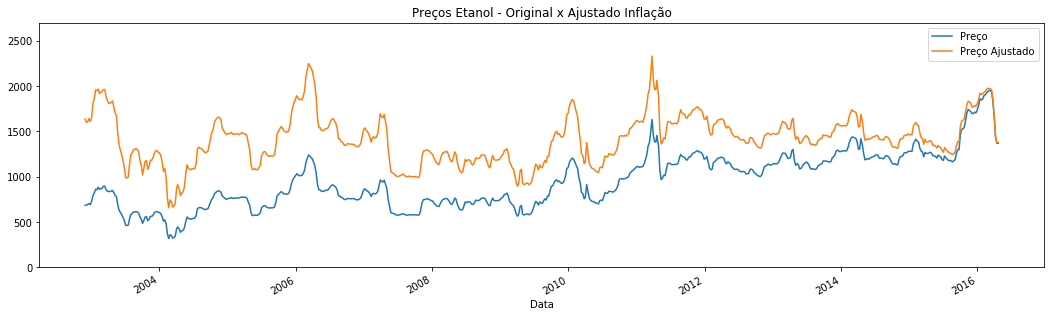

In [20]:
treino.loc[:,['Preço','Preço Ajustado']].plot(figsize=(18,5), title='Preços Etanol - Original x Ajustado Inflação')
plt.ylim([0,2700])
plt.show()

## Reduzindo a variância

### Logaritmo

O logaritmo geralmente é usado para transformar séries que tem valores com crescimentos exponenciais em séries com crescimentos mais lineares, neste exemplo usaremos o Logaritmo Natural (LN), onde a base é 2,718, este tipo de logaritmo é bastante usado em modelos econômicos.

A diferença dos valores transformados em LN são aproximadamente equivalentes à variação percentual dos valores da série original, o que vale como base para redução da variância em séries com preços diferentes, veja o exemplo abaixo:

    Se tivermos um produto que teve aumento de preços no ano de 2000 e saiu de R$ 50,00 para 52,50, algums anos depois (2019) o preço já estava em R$ 100,00 e alterou para R$ 105,00, a diferença absoluta entre os preços é de R$ 2,50 e R$ 5,00 respectivamente, porém a diferença percentual de ambos é de 5%.
    
    Ao usarmos o LN nesses preços temos: LN(52,50) - LN(50,00) = 3,96 - 3,912 = 0,048 ou seja 4,8%,
    do mesmo jeito usando o LN na segunda sequência de preços temos: LN(105) - LN(100) = 4,654 - 4,605 = 0,049 ou seja 4,9%.
    
Nesse exemplo conseguimos diminuir a variação dos valores trazendo quase para a mesma base de variação.

Abaixo o mesmo exemplo:

In [21]:
preco1 = np.log(52.5) - np.log(50)
preco2 = np.log(105) - np.log(100)
print(f'A variação percentual do primeiro exemplo é {round(preco1*100,1)}% e do segundo é {round(preco2*100,1)}%')

A variação percentual do primeiro exemplo é 4.9% e do segundo é 4.9%


Abaixo a tabela comparando valores de variação percentual de X com os valores de variação do LN(X):

<img src="comparativoLN.gif"> [Fonte](http://people.duke.edu/~rnau/411log.htm)

Vamos plotar os gráficos para ver como ficarão os preços com o ajuste de LN

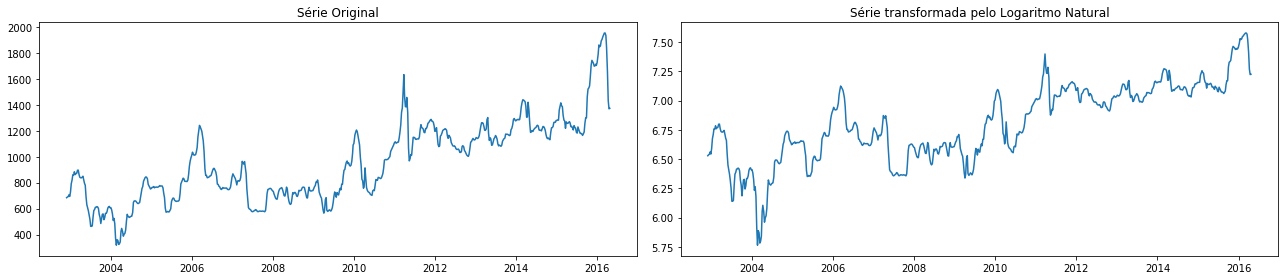

In [22]:
plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(treino['Preço'])
plt.title('Série Original')

#Série transformada pelo LN
log = np.log(treino['Preço'])
plt.subplot(122)
plt.plot(log)
plt.title('Série transformada pelo Logaritmo Natural')
plt.tight_layout()
plt.show()

### Transformação de Box-Cox (Power Transform)

A transformação de BOX COX é também uma maneira de transformar uma série através do valor base da função que neste caso é **_lambda_** ($\lambda$), resumindo, esta função é a junção de várias funções de transformação exponêncial, onde busca-se o melhor valor de *lambda* que transforme a série para que fique com uma distribuição mais próxima de uma [distribuição normal gaussiana](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal). Uma pré condição para essa transformação é que a série só tenha valores positivos, a fórmula é:

$X={\begin{cases}{\dfrac {X^{\lambda }-1}{\lambda }},&{\text{se }}\lambda \neq 0\\[12pt]\operatorname \ln {(X)}&{\text{se }}\lambda =0\end{cases}}$

Abaixo irei plotar o gráfico da série original com sua distribução e logo depois a série transformada com o valor ideal de lambda com sua nova distribuição, para encontrar o valor de lambda vamos usar a função **boxcox** da biblioteca [Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html), onde ele gera a série transformada e o lambda ideal:

O valor do Lambda foi 0.25033941108838


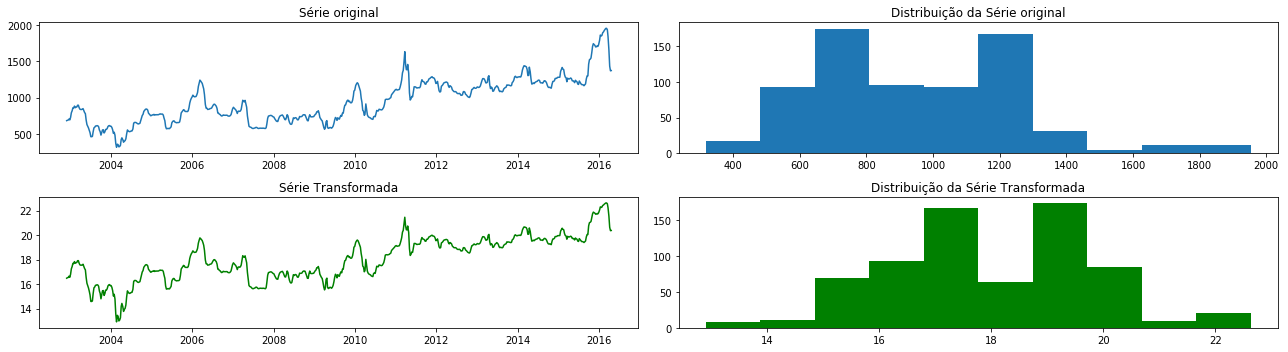

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(221)
plt.plot(treino['Preço'])
plt.title('Série original')

plt.subplot(222)
plt.hist(treino['Preço'])
plt.title('Distribuição da Série original')

#Transformando a série
from scipy.stats import boxcox
treino['BOXCOX'], lmbda_ = boxcox(treino['Preço'])
print(f'O valor do Lambda foi {lmbda_}')

plt.subplot(223)
plt.plot(treino['BOXCOX'], color='green')
plt.title('Série Transformada')

plt.subplot(224)
plt.hist(treino['BOXCOX'], color='green')
plt.title('Distribuição da Série Transformada')
plt.tight_layout()

Abaixo um gráfico interativo, onde pode-se mudar o valor de **lambda** e verificar a mudança no gráfico

In [24]:
import ipywidgets as widgets
from ipywidgets import interactive

def f(lmbda):
    plt.figure(figsize=(18,4))
    if lmbda == 0:
        treino['Box Cox'] = np.log(treino['Preço'])
    else:
        treino['Box Cox'] = (treino['Preço']**lmbda - 1)/lmbda
    plt.plot(treino['Box Cox'])
    plt.title(f'Transformação de Box Cox com Lambda de {lmbda}', fontdict={'fontsize':16})
    plt.show()

interactive_plot = interactive(f, lmbda=(-5,5,0.5))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='lmbda', max=5.0, min=-5.0, step=0.5), Output()), _dom_classes=('widget-interact',))

Essa ferramenta geralmente é usada para melhorar o desempenho do modelo, pois torna ele com distribuições mais normais, lembrando que depois de terminar a previsão do modelo, deve-se voltar à base original desfazendo a transformação conforme fórmula abaixo:

$X={\begin{cases}{(X \lambda+1)^{1/ \lambda }},&{\text{se }}\lambda \neq 0\\[12pt]\operatorname \exp {(X)}&{\text{se }}\lambda =0\end{cases}}$

## À procura de lags correlacionados

Para ter previsibilidade uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (**lag**).

Como esta série de preços tem períodos semanais, 1 ano tem aproximadamente 52 semanas, irei usar a função de auto correlação para um período de 60 lags para verificar correlações do período atual com estes lags.

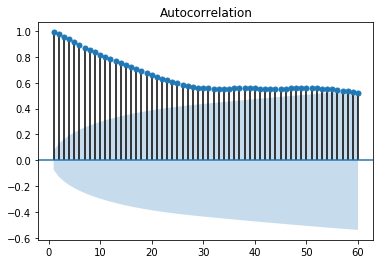

In [25]:
plot_acf(treino['Preço'], lags=60, zero=False);

Ao analisar o gráfico de auto correlação gerado acima acredita-se que todos os lags poderiam ser usados para criar previsões para eventos futuros, pois todos tem uma correlação positiva próximo de 1 e estão fora do intervalo de confiança, porém essa característica de auto correlação é de uma série não estacionária.

Uma outra função extremamente importante é a função de auto correlação parcial, onde o efeito do lag anterior sobre o período atual é removido e só resta o efeito do lag analisado sobre o período atual, exemplo: a auto correlação parcial do quarto lag irá remover o efeito do primeiro, segundo e terceiro lag.

Abaixo o gráfico de auto correlação parcial:

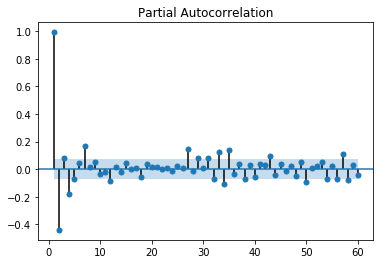

In [26]:
plot_pacf(treino['Preço'], lags=60, zero=False);

Como pode ser visto, quase nenhum lag tem efeito sobre o período atual, porém como demonstrado anteriormente, a série sem diferenciação não é estacionária, iremos plotar agora essas duas funções com a série com uma diferenciação para ver como fica:

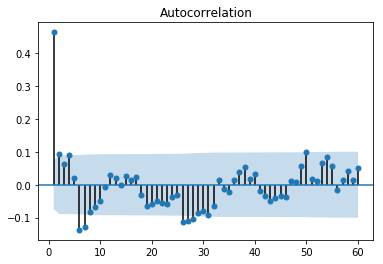

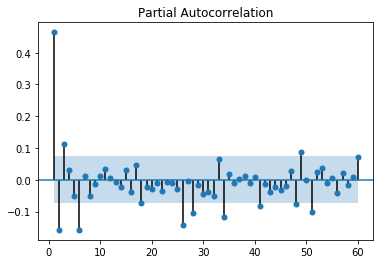

In [27]:
plot_acf(treino['Preço'].diff().dropna(), lags=60, zero=False);
plot_pacf(treino['Preço'].diff().dropna(), lags=60, zero=False);

O gráfico de auto correlação mudou significativamente, mostrando que a série tem correlação significativa somente no primeiro lag e um efeito sazonal com correlação negativa ao redor do vigésimo sexto mês (metade de um ano).

Um detalhe extremamente importante sobre encontrar lags correlacionados para criar previsões é que é importante que haja uma razão para que esta correlação exista, pois caso não haja alguma razão lógica é possível que seja só o acaso ou que a parte que está sendo analisada apresentou esta correlação, podendo mudar ao analisar outra parte da série.

Outro ponto importante é que os gráficos de auto correlação e autocorrelação parcial são muito sensíveis à pontos fora da curva (outliers), assim, é importante que se analise o gráfico da série normal para conferir com os dois gráficos de correlação.

Neste exemplo o primeiro lag tem uma correlação alta com o período atual, pois os preços da semana anterior historicamente não variam significativamente, no mesmo caso o vigésimo sexto lag apresenta uma correlação negativa, indicando uma tendência contrária ao período atual, provavelmente devido à periodos de oferta e demanda bastante diferentes ao longo de um ano.

Como a série com o preço ajustado pela inflação se tornou estacionária, usaremos ela no momento de fazer as previsões, abaixo os gráficos de auto correlação e autocorrelação parcial da série ajustada: 

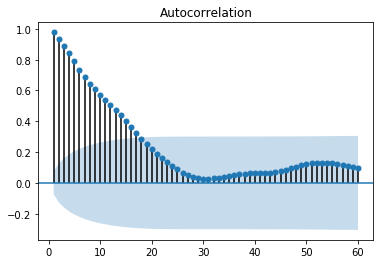

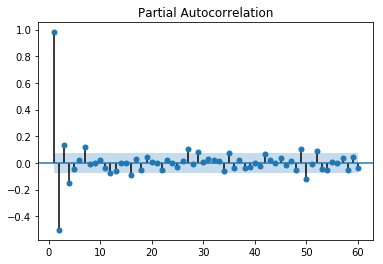

In [28]:
plot_acf(treino['Preço Ajustado'], lags=60, zero=False);
plot_pacf(treino['Preço Ajustado'], lags=60, zero=False);

Usaremos somente os dois primeiros lags como fator de previsão para séries auto regressivas.

Para mais informações, o site do professor [Robert Nau](http://people.duke.edu/~rnau/411home.htm) da Duke University é um dos melhores relacionados ao assunto.

## Métricas para avaliar o modelo

Para analisar se as previsões estão com os valores próximos dos dados reais deve-se fazer a medição do erro, o erro (ou **resíduo**) neste caso é basicamente $Y_{REAL} - Y_{PREVISÃO}$.

Avalia-se o erro nos dados de treino para verificar se o modelo tem boa assertividade, e valida-se o modelo verificando o erro nos dados de teste (dados que não foram "vistos" pelo modelo).

Abaixo estão as principais métricas usadas para avaliar modelos de séries temporais:

### MEAN FORECAST ERROR -  (ERRO MÉDIO DA PREVISÃO ou VIÉS)

O erro médio da previsão nada mais é do que a média dos erros da série avaliada, os valores podem ser positivos ou negativos. Essa métrica sugere que o modelo tende a fazer previsões acima do real (erros negativos) ou abaixo do real (erros positivos), desse modo também pode-se dizer que o **erro médio** é o viés do modelo.

### MAE - MEAN ABSOLUTE ERROR - (ERRO MÉDIO ABSOLUTO)

Essa métrica é muito semelhante ao erro médio da previsão mencionado acima, a única diferença é o erro com valor negativo, ou seja, a previsão com valor maior que o número real, é transformado em positivo e posteriormente a média é calculada. 

Essa métrica é muito usada em séries temporais, pois há casos que o erro negativo pode zerar o positivo ou dar uma ideia que o modelo é preciso, no caso do MAE isso não acontece, pois essa métrica mostra o quanto a previsão está longe dos valores reais, independente se acima ou abaixo, veja o caso abaixo:

In [29]:
a = np.array([1,2,3,4,5])
b = np.array([5,4,3,2,1])

erro = a - b

MFE = erro.mean()
MAE = np.abs(erro).mean()
print(f'O erro de cada valor do modelo ficou assim: {erro}')
print(f'O cálculo do erro da MFE é {MFE}, o erro da MAE é {MAE}')

O erro de cada valor do modelo ficou assim: [-4 -2  0  2  4]
O cálculo do erro da MFE é 0.0, o erro da MAE é 2.4


### MSE - MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO)

Essa métrica coloca mais peso nos erros maiores, pois cada valor individual do erro é elevado ao quadrado e posteriormente a média desses valores é calculada. Assim, essa métrica é muito sensível à *outliers* e coloca bastante peso nas previsões com erros mais significativos.

Diferente do MAE e MFE, os valores do MSE estão em unidades quadráticas e não na unidade do modelo.

### RMSE - ROOT MEAN SQUARED ERROR - (ERRO QUADRÁTICO MÉDIO DA RAIZ)

Essa métrica é simplesmente a raiz quadrada do MSE, onde o erro volta a ter a unidade de medida do modelo (R$/m3), ela é muito usada em séries temporais porque é mais sensível à erros maiores devido ao processo de elevação ao quadrado que a originou.

### MAPE - MEAN ABSOLUTE PERCENTAGE ERROR - (ERRO PERCENTUAL MÉDIO ABSOLUTO)

Essa é outra métrica interessante de ser usada, geralmente usada em relatórios gerenciais, pois o erro é medido em termos percentuais e pode-se comparar o erro percentual do modelo de um produto X com o erro percentual de um produto Y.

O cálculo dessa métrica pega o valor absoluto do erro dividido pelo preço real e posteriormente é calculada a média:

${\displaystyle {\mbox{MAPE}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {Y_{REAL}-Y_{PREVISTO}}{Y_{REAL}}}\right|,}$

Vamos criar uma função para avaliar o erro dos dados de treino e teste com várias métricas de avaliação:

In [30]:
#Bibliotecas para criar a função:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

# Checando os valores residuais

Criar o modelo e verificar o valor do seu resíduo de acordo com a métrica escolhida não é suficiente, é necessário analisar também o próprio resíduo, pois há casos em que o modelo não consegue capturar as informações necessárias para se fazer uma boa previsão resultando em um resíduo com "informações na mesa".

Para verificar este resíduo iremos checar:

* **Valores reais vs previstos (sequencial);**
* **Resíduo vs valores previstos (dispersão):**
    * É muito importante analisar este gráfico, pois nele podemos verificar padrões que podem nos dizer se é necessária alguma modificação no modelo, o ideal é que o erro esteja distribuído linearmente ao longo da sequência da previsão.
* **[QQ plot](https://pt.wikipedia.org/wiki/Gr%C3%A1fico_Q-Q) do resíduo (dispersão):**
    * Resumindo esse é um gráfico que mostra onde o resíduo deveria estar distribuído teoricamente, seguindo uma distribuição gaussiana, contra como ele realmente ficou.
* **Autocorrelação do resíduo (sequencial):**
    * Onde não deve haver valores que saiam da margem de confiança, ou o modelo está deixando informação na mesa.
   
Para isso precisamos criar outra função para plotar estes gráficos:

In [31]:
def plotar_erro(dados, figsize=(18,8)):
    
    # Criando a coluna do erro
    dados['Erro'] = dados.iloc[:,0] - dados.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotando os valores reais e previstos
    ax1.plot(dados.iloc[:,0:2])
    ax1.legend(['Real','Prev'])
    ax1.set_title('Valores Reais vs Previstos')
    
    # Erro vs Valores previstos
    ax2.scatter(dados.iloc[:,1], dados.iloc[:,2])
    ax2.set_xlabel('Valores Previstos')
    ax2.set_ylabel('Resíduo')
    ax2.set_title('Resíduo vs Valores Previstos')
    
    ## QQ Plot do erro
    sm.graphics.qqplot(dados.iloc[:,2], line='r', ax=ax3)
    
    # Gráfico de autocorrelação do Erro
    plot_acf(dados.iloc[:,2], lags=60,zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

## Formas mais básicas para se fazer uma previsão

A partir de agora iremos criar alguns modelos de previsão de preços do etanol Hidratado, abaixo estarão os passos que iremos seguir para cada modelo:

* Criar previsão nas base de treino posteriormente validar na base de teste;
* Checar o erro de cada modelo de acordo com as métricas mencionadas acima;
* Plotar o modelo com os comparativos do resíduo.

Vamos aos modelos:

### Abordagem Simples: 

A maneira mais simples de se fazer uma previsão é usar o valor do período anterior, há casos que essa é a melhor abordagem que pode ser feita, onde o erro fica inferior às outras formas de previsão, porém usar essa metodologia para prever vários períodos adiante geralmente não funciona bem, pois os erros em relação ao valores reais tendem a aumentar. 

Muitas pessoas também usam essa abordagem como **_baseline_** para tentar melhorar com modelos mais complexos.

Abaixo vamos usar os dados de treino e teste para fazer as simulações:

In [32]:
#Criando variável de treino para comparar o erro posteriormente
simples_treino = treino[['Preço Ajustado']]
simples_treino.columns = ['Real']
simples_treino['Previsão'] = simples_treino['Real'].shift()
simples_treino.dropna(inplace=True)

Vamos criar uma variável para checar o erro do treino deste modelo, também vamos plotar os gráficos mencionados anteriormente:

MODELO SIMPLES NA BASE DE TREINO


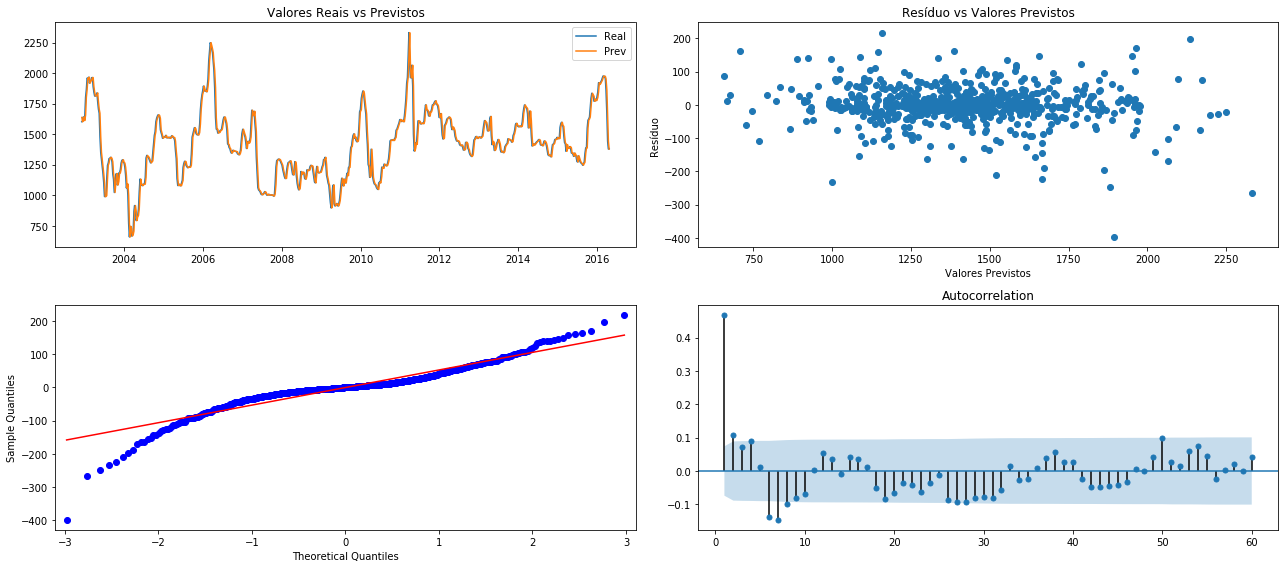

,Simples
Base Treino,
VIÉS,-0.366072
MSE,3101.487631
RMSE,55.691001
MAE,35.180332
MAPE,2.578871


In [33]:
erro_treino = check_erro(simples_treino['Real'], 
                         simples_treino['Previsão'], 
                         nome_col='Simples', 
                         nome_indice='Base Treino')

print('MODELO SIMPLES NA BASE DE TREINO')
plotar_erro(simples_treino)
erro_treino

O gráfico QQ mostra que há alguns resíduos maiores (para cima e para baixo) do que teoricamente deveriam haver que são os chamados outliers, e ainda existe uma autocorrelação significativa no primeiro, sexto e sétimo lag, os quais poderiam ser usados para melhorar o modelo. 

Do mesmo modo iremos agora fazer a previsão nos dados de teste. O primeiro valor da série prevista será o último dos dados de treino, posteriormente esses valores serão atualizados passo-a-passo pelo primeiro valor do teste e assim por diante:

MODELO SIMPLES NA BASE DE TESTE


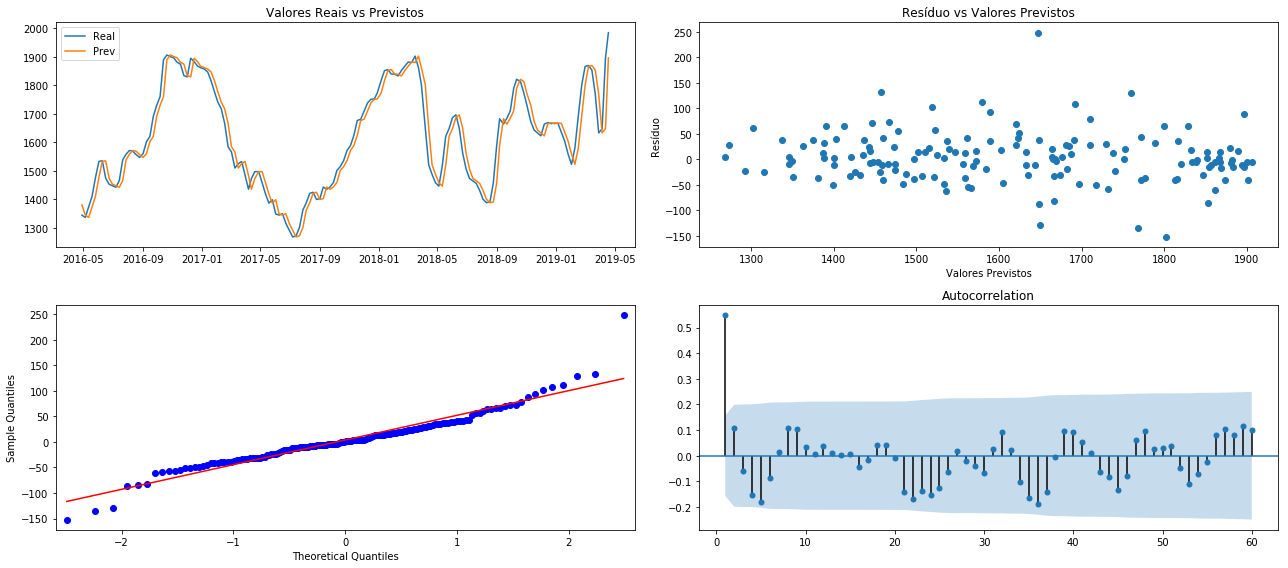

,Simples
Base Teste,
VIÉS,3.870050
MSE,2404.933394
RMSE,49.040120
MAE,34.474822
MAPE,2.129105


In [34]:
simples_teste = teste[['Preço']]
simples_teste.columns = ['Real']

#adicionando o primeiro valor da Previsão com o último dado Real do teste
hist = [simples_treino.iloc[i,0] for i in range(len(simples_treino))]
prev = []
for t in range(len(simples_teste)):
    yhat = hist[-1]
    obs = simples_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)

simples_teste['Previsão'] = prev

#criando a base de erro no teste
erro_teste = check_erro(simples_teste['Real'], 
                        simples_teste['Previsão'], 
                        nome_col='Simples',
                       nome_indice='Base Teste')

print('MODELO SIMPLES NA BASE DE TESTE')
plotar_erro(simples_teste)
erro_teste

Os erros RMSE e MAE ficaram semelhantes aos dados de treino, o gráfico QQ está com os resíduos mais alinhados com o que deveria teoricamente estar, provavelmente devido à poucos valores de amostras comparado com o treino.

No gráfico que compara os resíduos com os valores previstos nota-se que há uma tendência de os erros aumentarem em valores absolutos quando os preços aumentam, talvez um ajuste com logaritmos diminuísse essa expansão dos erros, e para finalizar o gráfico de auto correlação dos resíduos mostram que ainda há espaço para melhoras, pois há uma correlação forte no primeiro lag, onde provavelmente poderia ser adicionada uma regressão com base no primeiro lag para melhorar as previsões.

Próximo modelo é o de médias simples:

### Média simples:

Outra forma de se fazer previsões, é usar a média da série, geralmente esta forma de previsão fica boa quando os valores oscilam ao redor da média, com variância constante e sem tendências de alta ou de baixa, porém é possível usar métodos melhores, onde possa fazer a previsão usando padrões sazonais entre outros.

Este modelo usa a média do início dos dados até a data anterior e vai expandindo diariamente até o final dos dados, no final a tendência é que a linha fique reta, vamos agora comparar o erro deste modelo com o primeiro:

In [35]:
ms_treino = treino[['Preço Ajustado']]
ms_treino.columns = ['Real']
ms_treino['Previsão'] = ms_treino['Real'].expanding().mean()

#Verificando o erro do modelo de média simples
erro_treino['Média Simples'] = check_erro(ms_treino['Real'], ms_treino['Previsão'])
erro_treino.round(4)

,Simples,Média Simples
Base Treino,,
VIÉS,-0.3661,20.9485
MSE,3101.4876,72120.8110
RMSE,55.6910,268.5532
MAE,35.1803,207.1473
MAPE,2.5789,15.4983


Na base de testes continuarei a usar a média do início dos dados do treino e farei a expansão da média de acordo com os valores que serão acrescentados nos dados de teste:

MODELO DE MÉDIA SIMPLES NA BASE DE TESTE


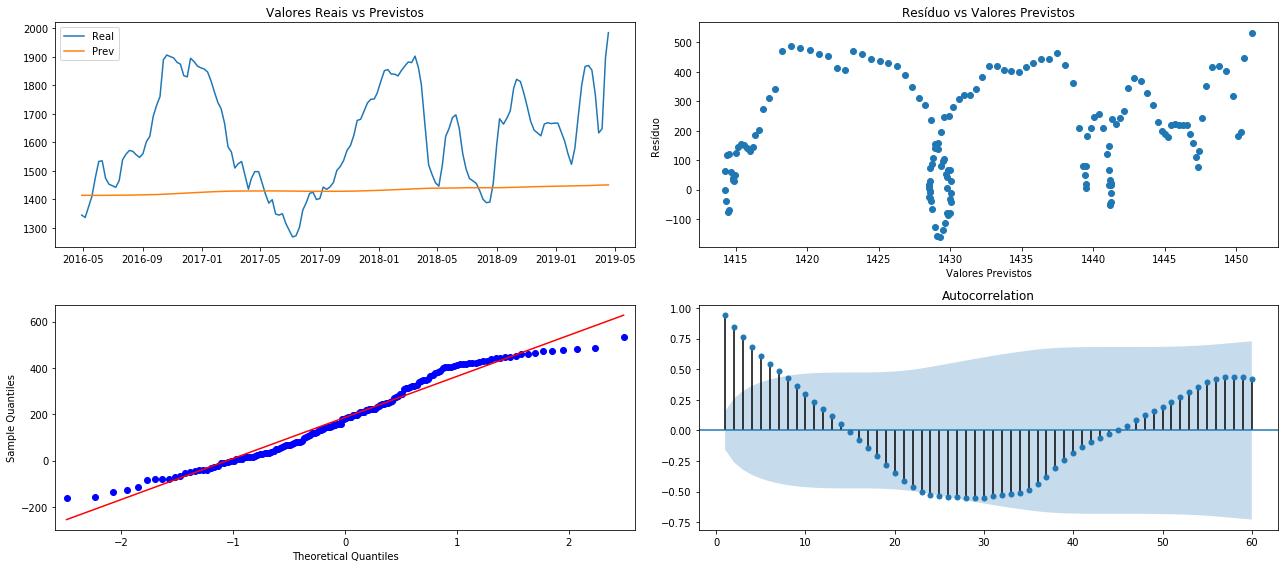

,Simples,Média Simples
Base Teste,,
VIÉS,3.870050,186.406394
MSE,2404.933394,65246.758682
RMSE,49.040120,255.434451
MAE,34.474822,206.110857
MAPE,2.129105,11.943455


In [36]:
ms_teste = teste[['Preço']]
ms_teste.columns = ['Real']

# Continuando a usar a média para a série de testes
hist = [ms_treino.iloc[i,0] for i in range(len(ms_treino))]
prev = []
for t in range(len(ms_teste)):
    yhat = np.mean(hist)
    obs = ms_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)

ms_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO DE MÉDIA SIMPLES NA BASE DE TESTE')
plotar_erro(ms_teste)

#Adicionando o erro da média simples no teste:
erro_teste['Média Simples'] = check_erro(ms_teste['Real'], ms_teste['Previsão'])
erro_teste

O modelo de média simples não conseguiu capturar informações relevantes da série de preços, como pode ser visto no gráfico de Real vs Previsto como também nos gráficos de auto correlação e Resíduos vs Previsto.

### Média móvel simples:

A média móvel é uma média que é calculada por um período determinado (5 dias por exemplo) e vai se movendo e sendo calculada sempre usando este período determinado, neste caso estaremos usando sempre a média os últimos 5 dias para prever o valor do dia seguinte.

In [37]:
mm_treino = treino[['Preço Ajustado']]
mm_treino.columns = ['Real']
mm_treino['Previsão'] = mm_treino.rolling(5).mean()
mm_treino.dropna(inplace=True)

# Checando o erro do modelo de treino de médias móveis
erro_treino['Média Móvel 5D'] = check_erro(mm_treino['Real'], mm_treino['Previsão'])
erro_treino.round(4)

,Simples,Média Simples,Média Móvel 5D
Base Treino,,,
VIÉS,-0.3661,20.9485,-0.5812
MSE,3101.4876,72120.8110,6422.5258
RMSE,55.6910,268.5532,80.1407
MAE,35.1803,207.1473,54.5744
MAPE,2.5789,15.4983,4.0041


O erro ficou inferior à média simples, porém ainda acima do modelo simples, abaixo o modelo de teste

MODELO DE MÉDIA MÓVEL DE 5 DIAS NA BASE DE TESTE


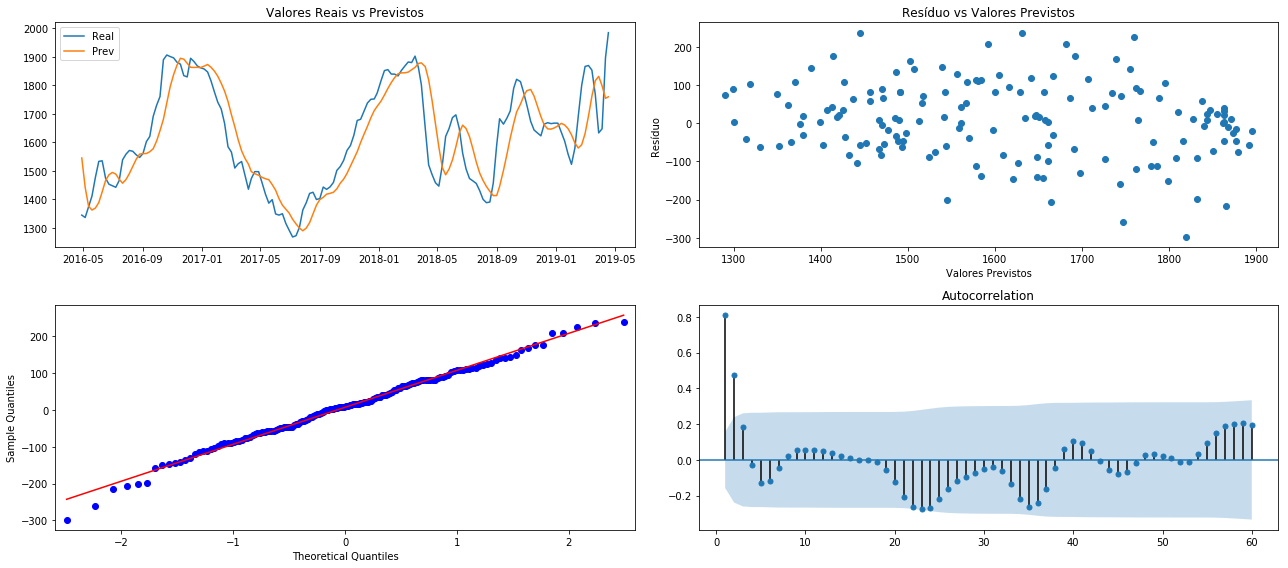

,Simples,Média Simples,Média Móvel 5D
Base Teste,,,
VIÉS,3.870050,186.406394,7.121677
MSE,2404.933394,65246.758682,9640.680668
RMSE,49.040120,255.434451,98.186968
MAE,34.474822,206.110857,77.540385
MAPE,2.129105,11.943455,4.814632


In [38]:
mm_teste = teste[['Preço']]
mm_teste.columns = ['Real']

# Continuando a usar a média móvel de 5 dias passo a passo:
hist = [mm_treino.iloc[i,0] for i in range(len(mm_treino))]
prev = []
for t in range(len(mm_teste)):
    yhat = np.mean(hist[-5:])
    obs = mm_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    
mm_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO DE MÉDIA MÓVEL DE 5 DIAS NA BASE DE TESTE')
plotar_erro(mm_teste)

# Checando o erro do modelo de teste de médias móveis
erro_teste['Média Móvel 5D'] = check_erro(mm_teste['Real'], mm_teste['Previsão'])
erro_teste

Do mesmo modo que o treino, o modelo de médias móveis estão melhores do que a média simples, porém ainda não ganham do modelo simples.

As previsões estão com auto correlação em dois lags e o erro está com uma variância muito alta em relação aos valores previstos.

### Média Móvel Exponencial:

O modelo de **média móvel simples** descrito acima tem a propriedade de tratar as últimas **X** observações igualmente e ignorar completamente todas as observações anteriores. Intuitivamente, dados passados devem ser descontados de forma mais gradual, por exemplo, a observação mais recente teoricamente deve ter um pouco mais de peso do que o segundo mais recente, e o segundo mais recente deve ter um pouco mais de peso que o terceiro mais recente, e assim por diante, o modelo de **Média móvel exponencial (MME)** faz isso.

Sendo **$\alpha$** (alpha) uma constante com valor entre 0 e 1, iremos calcular a previsão com a fórmula a seguir:

$ Ypred_{t} = Ypred _{t-1} + \alpha(Y_{t-1} - Ypred_{t-1})$

Onde o primeiro valor da previsão é o valor atual respectivo, os outros valores irão ser atualizados por $\alpha$ vezes a diferença entre o valor real e a previsão do período anterior. Quando alpha é zero temos uma constante baseada no primeiro valor da previsão, quando $\alpha$ é 1 temos um modelo com **abordagem simples**, pois o resultado é o valor do período anterior.

Abaixo um gráfico com vários valores de $\alpha$:

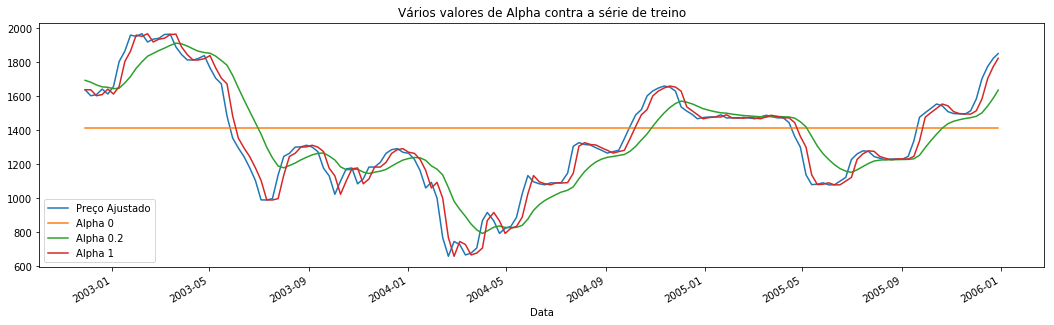

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
mme = treino[['Preço Ajustado']]
alpha_ = [0, 0.2, 1]
for key, valor in enumerate(alpha_):
    model = ExponentialSmoothing(mme['Preço Ajustado']).fit(smoothing_level= valor)
    mme[f'Alpha {valor}'] = model.predict(start=0, end=len(mme)-1)

#plotando parte do gráfico para melhorar a visualização
mme[:'2005'].plot(figsize=(18,5), title='Vários valores de Alpha contra a série de treino')
plt.show()

O período médio dos dados na previsão de MME é 1 / $\alpha$. Por exemplo, quando $\alpha$ = 0,5, o lag é equivalente a 2 períodos; quando $\alpha$ = 0,2 o lag é de 5 períodos; quando $\alpha$ = 0,1 o lag é de 10 períodos e assim por diante.

Neste modelo iremos usar arbitrariamente um $\alpha$ de 0,50, porém você pode fazer um *grid search* para procurar o $\alpha$ que reduz o erro no treino e também na validação, vamos ver como vai ficar:

In [40]:
mme_treino = treino[['Preço Ajustado']]
mme_treino.columns = ['Real']

#criando o modelo:
alpha = 0.5
modelo = ExponentialSmoothing(mme_treino['Real']).fit(smoothing_level= alpha)
mme_treino['Previsão'] = modelo.predict(start=0, end=len(mme_treino)-1)

# Checando o erro do modelo de treino de médias móveis exponenciais
erro_treino['Média Móvel Exp.'] = check_erro(mme_treino['Real'], mme_treino['Previsão'])
erro_treino

,Simples,Média Simples,Média Móvel 5D,Média Móvel Exp.
Base Treino,,,,
VIÉS,-0.366072,20.948470,-0.581179,-0.540009
MSE,3101.487631,72120.810997,6422.525818,6364.944623
RMSE,55.691001,268.553181,80.140663,79.780603
MAE,35.180332,207.147333,54.574449,53.450252
MAPE,2.578871,15.498293,4.004098,3.917916


O erro deste modelo foi semelhante ao erro das médias móveis, porém temos que validar o modelo na base de testes:

MODELO DE MÉDIA MÓVEL EXPONENCIAL COM ALPHA DE 0,50 NA BASE DE TESTE


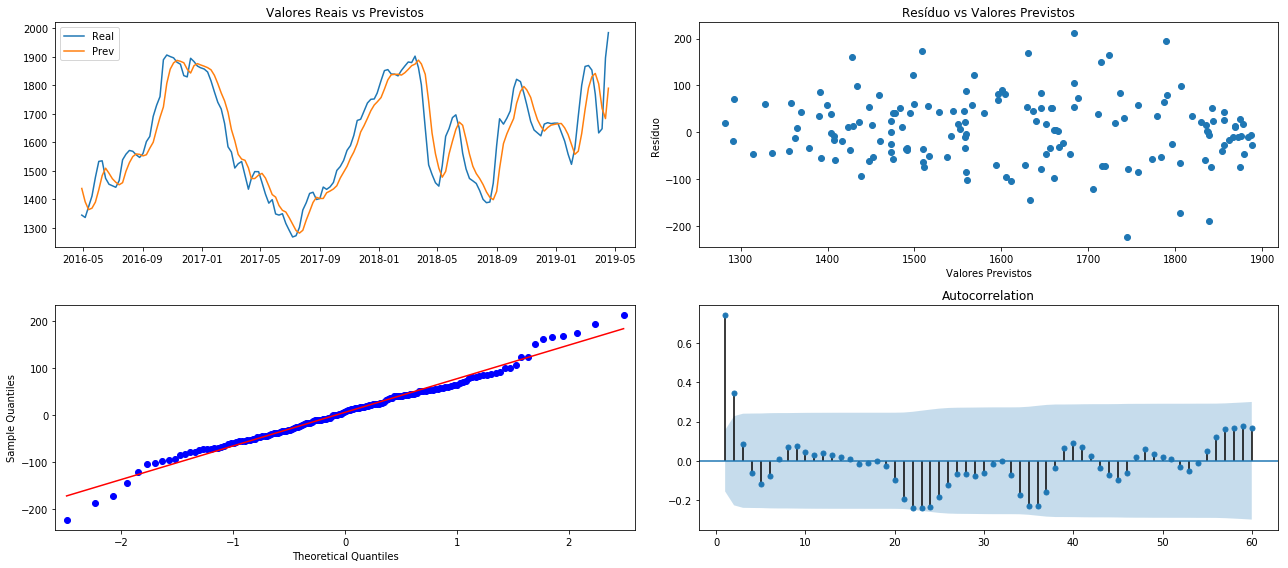

,Simples,Média Simples,Média Móvel 5D,Média Móvel Exp.
Base Teste,,,,
VIÉS,3.870050,186.406394,7.121677,5.752078
MSE,2404.933394,65246.758682,9640.680668,4973.613196
RMSE,49.040120,255.434451,98.186968,70.523848
MAE,34.474822,206.110857,77.540385,54.642774
MAPE,2.129105,11.943455,4.814632,3.380856


In [41]:
mme_teste = teste[['Preço']]
mme_teste.columns = ['Real']

#criando o modelo:
hist = [mme_treino.iloc[i,0] for i in range(len(mme_treino))]
hist_prev = [mme_treino.iloc[i,1] for i in range(len(mme_treino))]
prev = []
for t in range(len(mme_teste)):
    yhat = hist_prev[-1] + alpha * (hist[-1] - hist_prev[-1])
    obs = mme_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    hist_prev.append(yhat)

mme_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO DE MÉDIA MÓVEL EXPONENCIAL COM ALPHA DE 0,50 NA BASE DE TESTE')
plotar_erro(mme_teste)

# Checando o erro do modelo de treino de médias móveis exponenciais
erro_teste['Média Móvel Exp.'] = check_erro(mme_teste['Real'], mme_teste['Previsão'])
erro_teste

Na validação o erro até o momento é o segundo melhor dos modelos que já treinamos., porém as características dos gráficos dos resíduos são muito semelhantes aos gráficos do modelo da média móvel de 5 dias.

### Auto Regressivo:

Um modelo auto regressivo é basicamente uma regressão linear com lags significativamente correlacionados, onde inicialmente deve-se plotar o gráfico de autocorrelação e autocorrelação parcial para verificar se existe algo relevante, havendo, treina-se o modelo com estes lags.

Abaixo está o gráfico de autocorrelação e autocorrelação parcial da série de treino que mostra uma assinatura de modelo auto regressivo 2 lags com correlações significativas:

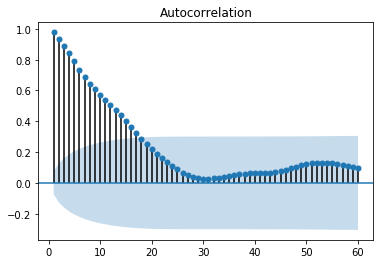

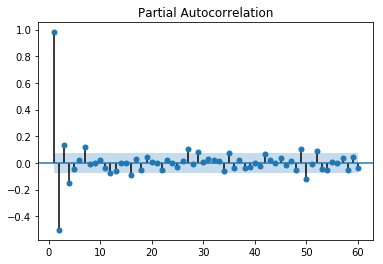

In [42]:
plot_acf(treino['Preço Ajustado'], lags=60, zero=False);
plot_pacf(treino['Preço Ajustado'], lags=60, zero=False);

Abaixo vamos criar o modelo com base nos dados de treino e após obter os coeficientes do modelo, iremos multiplicá-los pelos valores que forem sendo realizados pelos dados do teste:

In [43]:
ar_treino = treino[['Preço Ajustado']]
ar_treino.columns = ['Real']

#criando o modelo:
from statsmodels.tsa.arima_model import ARMA
modelo = ARMA(ar_treino['Real'], order=[2,0]).fit()
ar_treino['Previsão'] = modelo.predict(start=0, end=len(ar_treino)-1)

# Checando o erro do modelo auto regressivo
erro_treino['Auto Regr.'] = check_erro(ar_treino['Real'], ar_treino['Previsão'])
erro_treino

,Simples,Média Simples,Média Móvel 5D,Média Móvel Exp.,Auto Regr.
Base Treino,,,,,
VIÉS,-0.366072,20.948470,-0.581179,-0.540009,-0.029608
MSE,3101.487631,72120.810997,6422.525818,6364.944623,2415.825695
RMSE,55.691001,268.553181,80.140663,79.780603,49.151050
MAE,35.180332,207.147333,54.574449,53.450252,31.660520
MAPE,2.578871,15.498293,4.004098,3.917916,2.331906


Neste modelo o erro foi o menor em relação à todos os outros que treinamos, agora vamos usar os coeficientes dele para fazer a previsão passo-a-passo dos dados de treino:

MODELO AUTO REGRESSIVO NA BASE DE TESTE


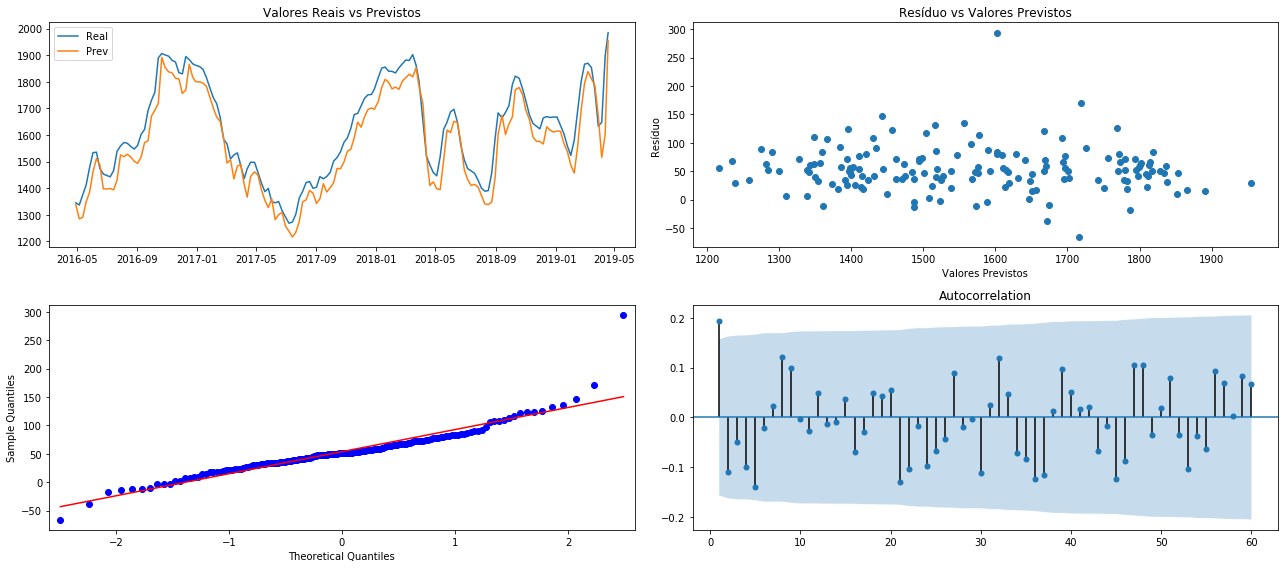

,Simples,Média Simples,Média Móvel 5D,Média Móvel Exp.,Auto Regr.
Base Treino,,,,,
VIÉS,-0.366072,20.948470,-0.581179,-0.540009,53.897706
MSE,3101.487631,72120.810997,6422.525818,6364.944623,4509.416686
RMSE,55.691001,268.553181,80.140663,79.780603,67.152190
MAE,35.180332,207.147333,54.574449,53.450252,56.164377
MAPE,2.578871,15.498293,4.004098,3.917916,3.466456


In [44]:
ar_teste = teste[['Preço']]
ar_teste.columns = ['Real']

#validando os dados usando os coeficientes do modelo treinado:
coef_l1, coef_l2 = modelo.arparams
hist = [ar_treino.iloc[i,0] for i in range(len(ar_treino))]
prev = []
for t in range(len(ar_teste)):
    yhat = (hist[-1] * coef_l1) + (hist[-2] * coef_l2)
    obs = ar_teste.iloc[t,0]
    prev.append(yhat)
    hist.append(obs)
    
ar_teste['Previsão'] = prev

#plotando o gráfico de teste
print('MODELO AUTO REGRESSIVO NA BASE DE TESTE')
plotar_erro(ar_teste)

# Checando o erro do modelo auto regressivo
erro_treino['Auto Regr.'] = check_erro(ar_teste['Real'], ar_teste['Previsão'])
erro_treino

Nota-se que na validação dos dados o erro não se manteve estável, ficando até pior que o **modelo simples**, note no gráfico que as previsões estão quase sempre abaixo dos valores reais, a medição do **Viés** mostra que os valores reais estão R$ 53,89 acima das previsões, talvez afinando alguns parâmetros no modelo de treino essa diferença diminuisse. 

Para melhorar estes modelos pode-se aplicar várias transformações, como as explicadas neste post para tentar melhorar a previsão, além disso pode-se adicionar variáveis externas como fonte de previsão, porém este é um assunto para outro post.

## Considerações Finais

Cada modelo de série temporal tem suas próprias características, devendo elas serem analisadas para podermos extrair o máximo de informação possível e consequentemente fazermos boas previsões para reduzir a incerteza do futuro.

Checar estacionariedade, transformar os dados, criar modelo, validar na base de testes, checar o erro são passos fundamentais para criar uma boa previsão de séries temporais.

Em breve também farei outro post relacionado à detalhes de modelos [ARIMA](https://pt.wikipedia.org/wiki/ARIMA).

Espero que tenha gostado, qualquer dúvida ou informação segue meu [LinkedIn](https://www.linkedin.com/in/leandro-rabelo-08722824) para contato.